In [19]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import seaborn as sns
import matplotlib.pyplot as plt

# Configurações visuais para os gráficos
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Bibliotecas importadas com sucesso!")


Bibliotecas importadas com sucesso!


In [7]:
# Definição dos arquivos de entrada
arquivos_alvo = [
    '202401_Licitacao.csv',
    #'202402_Licitacao.csv',
    #'202403_Licitacao.csv',
    #'202404_Licitacao.csv'
]

lista_df = []

# Processamento de leitura
for arquivo in arquivos_alvo:
    if os.path.exists(arquivo):
        print(f"Processando: {arquivo}")
        # Lendo com os parâmetros corretos de separador e encoding
        temp_df = pd.read_csv(arquivo, sep=';', encoding='utf-8', low_memory=False)
        lista_df.append(temp_df)
    else:
        print(f"Erro: Arquivo {arquivo} não encontrado.")

# União e salvamento
if lista_df:
    df = pd.concat(lista_df, ignore_index=True)
    arquivo_saida = "Licitacoes_2024_Quadrimestre_Consolidado.csv"
    df.to_csv(arquivo_saida, sep=';', encoding='iso-8859-1', index=False)
    
    print("-" * 30)
    print(f"Sucesso! Total de registros: {len(df)}")
else:
    print("Falha: Nenhum dado foi carregado.")


Processando: 202401_Licitacao.csv
------------------------------
Sucesso! Total de registros: 2537


In [8]:
df.describe()

,Número Licitação,Código UG,Código Modalidade Compra,Código Órgão Superior,Código Órgão
count,2.537000e+03,2537.000000,2537.000000,2537.000000,2537.000000
mean,9.312283e+07,261452.143871,4759.917225,37478.189594,35763.962554
std,2.705000e+08,217035.081149,4991.932298,13089.505261,13515.866567
min,1.202300e+04,30100.000000,2.000000,3000.000000,3000.000000
25%,2.020230e+05,154046.000000,5.000000,26000.000000,26263.000000
50%,5.720230e+05,158587.000000,6.000000,36000.000000,26443.000000
75%,1.422023e+06,250059.000000,9999.000000,52000.000000,52121.000000
max,9.900320e+08,926483.000000,9999.000000,84000.000000,91081.000000


In [13]:
# 1. Tratamento da coluna de Valor

df = df.rename(columns={"Valor Licitação": "Valor_Licitacao"})
df = df.rename(columns={"Data Resultado Compra": "Data_Resultado_Compra"})
df = df.rename(columns={"Data Abertura": "Data_Abertura"})
df = df.rename(columns={"Modalidade Compra": "Modalidade_Compra"})

# Removemos a vírgula e convertemos para numérico
df['Valor_Licitacao'] = (
    df['Valor_Licitacao']
    .astype(str)
    .str.replace(',', '.')
)
df['Valor_Licitacao'] = pd.to_numeric(df['Valor_Licitacao'], errors='coerce')

# 2. Tratamento das colunas de Data
colunas_data = ['Data_Resultado_Compra', 'Data_Abertura']
for col in colunas_data:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')

# 3. Cálculo da Duração (Feature Engineering)
df['Duracao_dias'] = (df['Data_Resultado_Compra'] - df['Data_Abertura']).dt.days

# Verificação final dos tipos
print("Novos tipos de dados nas colunas principais:")
print(df[['Valor_Licitacao', 'Data_Resultado_Compra', 'Data_Abertura', 'Duracao_dias']].dtypes)
print(f"\nValores nulos encontrados na Duração: {df['Duracao_dias'].isna().sum()}")


Novos tipos de dados nas colunas principais:
Valor_Licitacao                 float64
Data_Resultado_Compra    datetime64[ns]
Data_Abertura            datetime64[ns]
Duracao_dias                    float64
dtype: object

Valores nulos encontrados na Duração: 411


In [14]:
# 1. Criando o resumo novamente (garantindo que os dados estão limpos)
resumo_estatistico = df.groupby('Modalidade_Compra').agg({
    'Valor_Licitacao': ['count', 'mean', 'sum'],
    'Duracao_dias': 'mean'
}).reset_index()

# 2. Renomeando
resumo_estatistico.columns = [
    'Modalidade', 
    'Qtd_Processos', 
    'Valor_Medio', 
    'Valor_Total', 
    'Media_Dias_Processo'
]

# 3. Tratamento de NaNs (substitui por 0 onde não foi possível calcular a duração)
resumo_estatistico['Media_Dias_Processo'] = resumo_estatistico['Media_Dias_Processo'].fillna(0)

# 4. Ordenação
resumo_estatistico = resumo_estatistico.sort_values(by='Qtd_Processos', ascending=False)

# 5. Exibição Formatada (Sem notação científica e com separadores)
formatacao = {
    'Valor_Medio': 'R$ {:,.2f}',
    'Valor_Total': 'R$ {:,.2f}',
    'Media_Dias_Processo': '{:.1f} dias',
    'Qtd_Processos': '{:,}'
}

# Exibindo a tabela estilizada
resumo_estatistico.style.format(formatacao).hide(axis='index')


Modalidade,Qtd_Processos,Valor_Medio,Valor_Total,Media_Dias_Processo
Pregão - Registro de Preço,"1,207","R$ 366,977.23","R$ 442,941,512.16",43.8 dias
Pregão,744,"R$ 2,238,319.34","R$ 1,665,309,586.62",30.7 dias
Dispensa de Licitação,477,"R$ 42,102.25","R$ 20,082,775.44",1130.4 dias
Inexigibilidade de Licitação,58,"R$ 110,081.56","R$ 6,384,730.48",0.0 dias
Concorrência,27,"R$ 2,233,638.71","R$ 60,308,245.17",0.0 dias
Tomada de Preços,24,"R$ 779,830.47","R$ 18,715,931.33",0.0 dias


/tmp/ipykernel_3939/3688086910.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


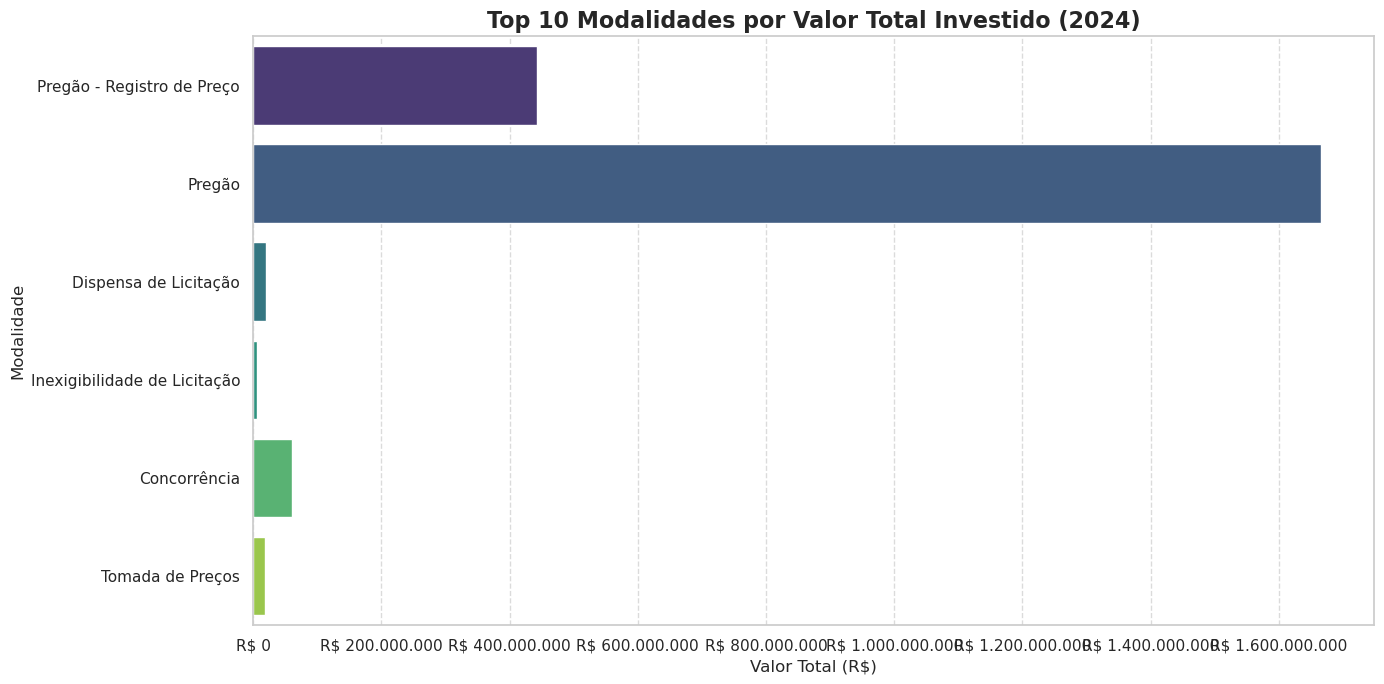

In [15]:
plt.figure(figsize=(14, 7))
ax = sns.barplot(
    data=resumo_estatistico.head(10), 
    x='Valor_Total', 
    y='Modalidade', 
    palette='viridis'
)

# Formatação de Moeda (R$) no eixo X
formatter = mticker.FuncFormatter(lambda x, p: f'R$ {x:,.0f}'.replace(',', 'X').replace('.', ',').replace('X', '.'))
ax.xaxis.set_major_formatter(formatter)

plt.title('Top 10 Modalidades por Valor Total Investido (2024)', fontsize=16, fontweight='bold')
plt.xlabel('Valor Total (R$)', fontsize=12)
plt.ylabel('Modalidade', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


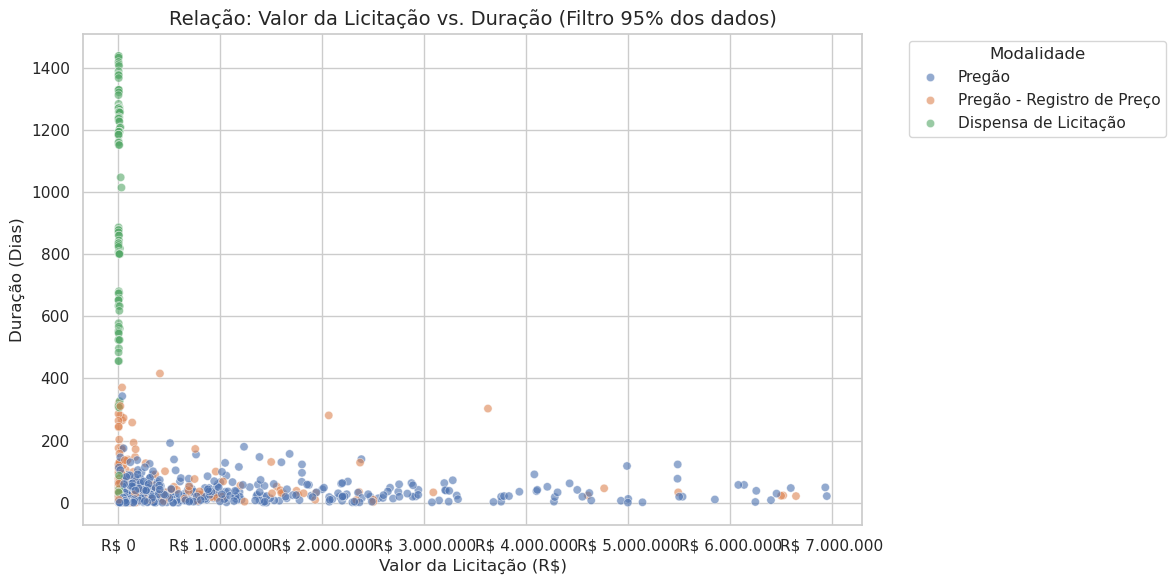

In [16]:
df_plot = df[(df['Valor_Licitacao'] > 0) & (df['Duracao_dias'] >= 0)].copy()

limite_valor = df_plot['Valor_Licitacao'].quantile(0.95)
limite_dias = df_plot['Duracao_dias'].quantile(0.95)

df_filtrado = df_plot[(df_plot['Valor_Licitacao'] <= limite_valor) & (df_plot['Duracao_dias'] <= limite_dias)]

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df_filtrado, 
    x='Valor_Licitacao', 
    y='Duracao_dias', 
    hue='Modalidade_Compra', 
    alpha=0.6
)

plt.title('Relação: Valor da Licitação vs. Duração (Filtro 95% dos dados)', fontsize=14)
plt.xlabel('Valor da Licitação (R$)', fontsize=12)
plt.ylabel('Duração (Dias)', fontsize=12)

# Formatação do eixo X como moeda
ax = plt.gca()
ax.xaxis.set_major_formatter(formatter)

plt.legend(title='Modalidade', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


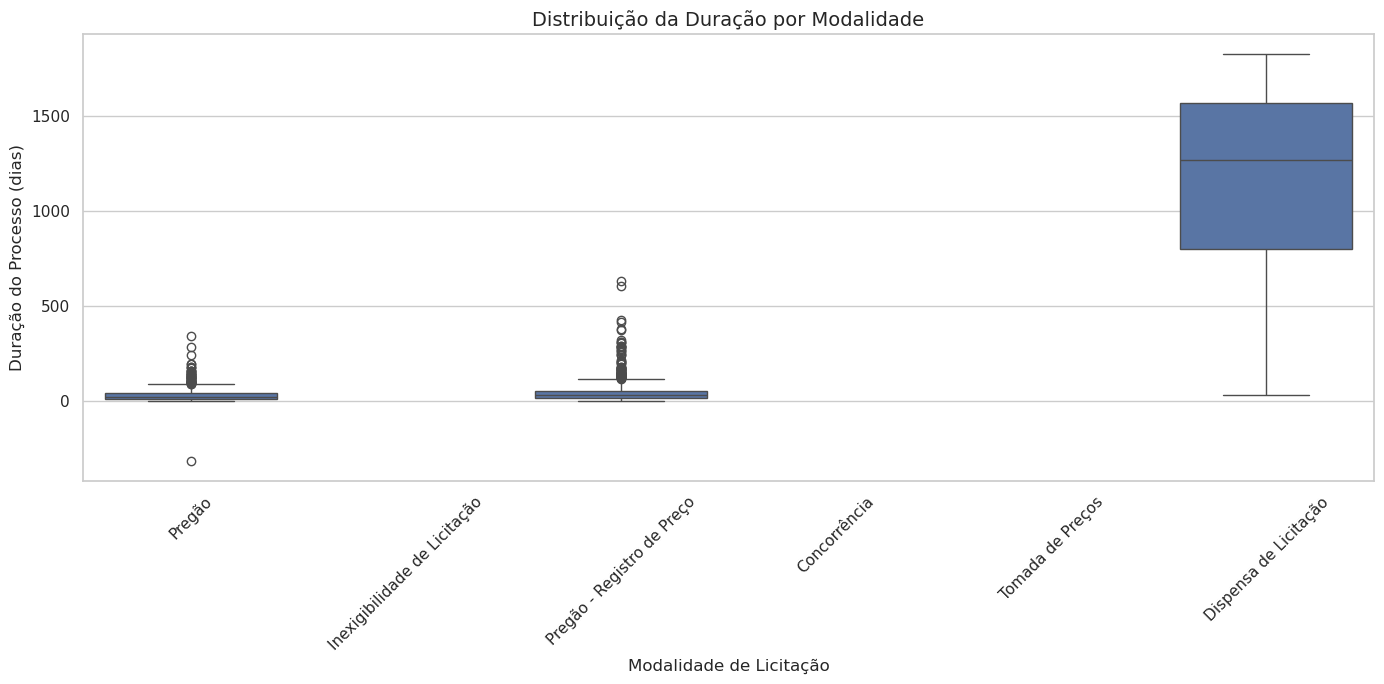

In [17]:
#  Distribuição da duração por modalidade (Boxplot) 

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

sns.boxplot(
    data=df,
    x='Modalidade_Compra',
    y='Duracao_dias'
)

plt.xticks(rotation=45)
plt.title('Distribuição da Duração por Modalidade', fontsize=14)
plt.xlabel('Modalidade de Licitação', fontsize=12)
plt.ylabel('Duração do Processo (dias)', fontsize=12)

plt.tight_layout()
plt.show()


In [18]:
# Detecção de casos anômalos 

# Calculando o limite superior do top 10% mais demorado
p90 = df['Duracao_dias'].quantile(0.90)

print(f"Percentil 90 da duração: {p90:.2f} dias")

# Criando coluna indicadora de possível reprocesso
df['Possivel_Reprocesso'] = df['Duracao_dias'] > p90

# Estatísticas por modalidade e grupo
resultado_analise = df.groupby(['Modalidade_Compra', 'Possivel_Reprocesso'])['Duracao_dias'] \
                      .agg(['count', 'mean', 'median']).reset_index()

print("\nResumo da análise de reprocessos:")
print(resultado_analise)


Percentil 90 da duração: 150.00 dias

Resumo da análise de reprocessos:
              Modalidade_Compra  Possivel_Reprocesso  count         mean  \
0                  Concorrência                False      0          NaN   
1         Dispensa de Licitação                False     17    51.000000   
2         Dispensa de Licitação                 True    158  1246.493671   
3  Inexigibilidade de Licitação                False      0          NaN   
4                        Pregão                False    732    27.886612   
5                        Pregão                 True     12   201.500000   
6    Pregão - Registro de Preço                False   1164    36.006873   
7    Pregão - Registro de Preço                 True     43   255.488372   
8              Tomada de Preços                False      0          NaN   

   median  
0     NaN  
1    48.0  
2  1326.0  
3     NaN  
4    21.0  
5   179.0  
6    28.0  
7   240.0  
8     NaN  


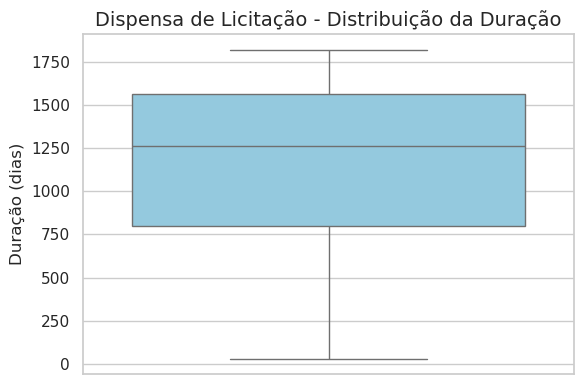

Gráfico 1 salvo como: boxplot_dispensa.png


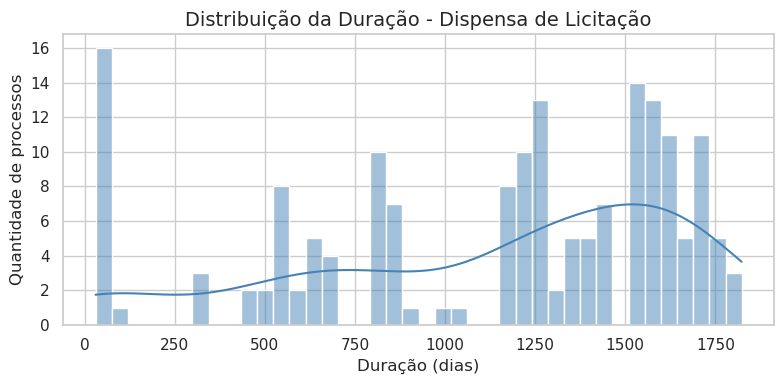

Gráfico 2 salvo como: histograma_dispensa.png


In [20]:
# Filtrar apenas dispensa
df_dispensa = df[df['Modalidade_Compra'] == 'Dispensa de Licitação']

# 1) Boxplot da Dispensa
plt.figure(figsize=(6, 4))
sns.boxplot(y=df_dispensa['Duracao_dias'], color='skyblue')
plt.title('Dispensa de Licitação - Distribuição da Duração', fontsize=14)
plt.ylabel('Duração (dias)')
plt.tight_layout()
plt.savefig('boxplot_dispensa.png', dpi=300)
plt.show()

print("Gráfico 1 salvo como: boxplot_dispensa.png")


# 2) Histograma da duração da Dispensa
plt.figure(figsize=(8, 4))
sns.histplot(df_dispensa['Duracao_dias'], bins=40, kde=True, color='steelblue')
plt.title('Distribuição da Duração - Dispensa de Licitação', fontsize=14)
plt.xlabel('Duração (dias)')
plt.ylabel('Quantidade de processos')
plt.tight_layout()
plt.savefig('histograma_dispensa.png', dpi=300)
plt.show()

print("Gráfico 2 salvo como: histograma_dispensa.png")
